In [1]:
import numpy as np
import pandas as pd

# Sklearn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Torch
import torch
import torch.nn as nn
#import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
#from torch.autograd import Variable
#from torchvision import datasets
#from torchvision.transforms import ToTensor
#from torch import tensor
#import torch.optim as optim
from torchinfo import summary

# Plotting
import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D
#import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Links

https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

https://medium.com/@deepeshdeepakdd2/lenet-5-implementation-on-mnist-in-pytorch-c6f2ee306e37

https://deepnote.com/workspace/ludekcizinsky-8f7f55a7-f3c7-4009-b3b2-b7b07fcdf5a7/project/ml202220-44b4318f-b707-4245-8a54-52edfdffa4de/notebook/dd926b1b8ea94ce79538cc9365bc74b7

### Load Data

In [2]:
# Load the data
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

# Scaling
X_train = data_train[:, :-1]/255
y_train = data_train[:, -1]

X_test = data_test[:, :-1]/255
y_test = data_test[:, -1]

In [3]:
# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).long()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long) 

# Reshape X_train and X_test for convolutional input (assuming 28x28 images)
X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size

# Create TensorDataset
data_train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
data_test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

# Split training into training and validation
g_cpu = torch.Generator()
g_cpu.manual_seed(3)
data_train_tensor, data_val_tensor = torch.utils.data.random_split(data_train_tensor, [8000, 2000])

### LeNet modified

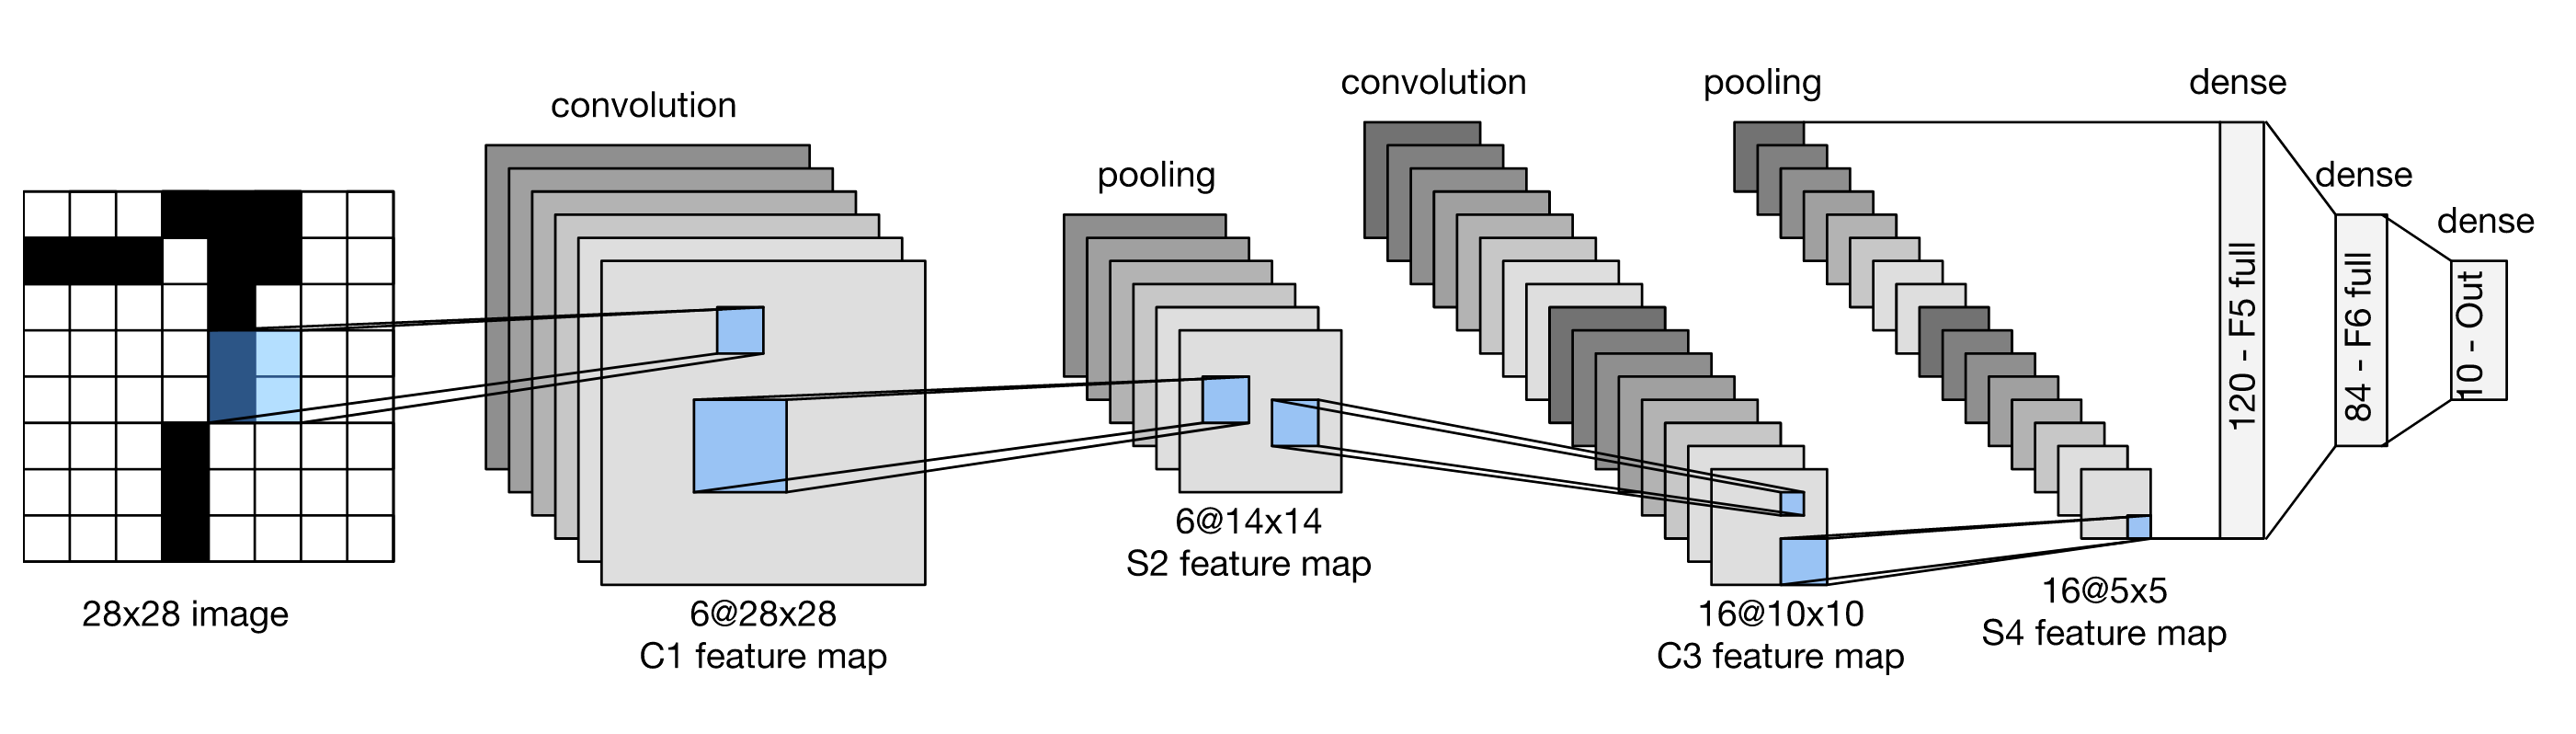

In [5]:
# Implementation is taken https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
class CNN(nn.Module):
    def __init__(self, activation_fn, drop_out_rate, batch_size, epochs, train_data, val_data, test_data, loss_fn, lr, optimizer, verbose, patience=7, delta=0):

        # Inherit from nn module
        super(CNN, self).__init__()

        # Define activation function
        self.activation_fn = activation_fn

        # Define drop ratio
        self.drop_out_rate = drop_out_rate
        
        # Define neural network architecture
        self.nn = nn.Sequential(

                # C1 6@28x28
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(6),
                self.activation_fn(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                
                # C3: 16@10x10
                #nn.Dropout(self.drop_out_rate),
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                self.activation_fn(),
                nn.AvgPool2d(kernel_size=2, stride=2),
                
                # Apply flattening on the output
                nn.Flatten(),
                
                # Dense part
                # L1
                nn.Dropout(self.drop_out_rate),
                nn.Linear(16 * 5 * 5, 120),
                nn.BatchNorm1d(120),
                self.activation_fn(),
                
                # L2
                nn.Dropout(self.drop_out_rate),
                nn.Linear(120, 84),
                nn.BatchNorm1d(84),
                self.activation_fn(),
                
                # L3
                nn.Dropout(self.drop_out_rate),
                nn.Linear(84, 10))

        # Define batch size
        self.batch_size = batch_size

        # Define numper of epochs
        self.epochs = epochs

        # Define datasets
        self.training_data = DataLoader(
            train_data, batch_size=self.batch_size, shuffle=True, num_workers=1)
        self.validation_data = DataLoader(
            val_data, batch_size=self.batch_size, shuffle=True, num_workers=1)
        self.test_data = DataLoader(
            test_data, batch_size=len(test_data), shuffle=True, num_workers=1)

        # Define loss function
        self.loss_fn = loss_fn

        # Define learning rate
        self.lr = lr

        # Define optimizer
        self.optimizer = optimizer(self.parameters(), lr=self.lr)

        # Print status if true
        self.verbose = verbose

        # Define patience and delta for early stopping
        self.patience = patience
        self.delta = delta

        # Save training progress
        self.train_loss_history = []
        self.train_acc_history = []

        self.val_loss_history = []
        self.val_acc_history = []
    
    def forward(self, x):
        logits = self.nn(x)
        return logits
    
    def train_loop(self):
        size = len(self.training_data.dataset)
        num_batches = len(self.validation_data)
        train_loss, correct = 0, 0

        for batch, (X, y) in enumerate(self.training_data):
            self.train() # Specify that model is training to enable batchnorm and dropout

            # Compute prediction and loss
            pred = self.forward(X)
            loss = self.loss_fn(pred, y)

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Calculate train loss and accuracy
            train_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            if self.verbose:
                if batch % 20 == 0:
                    loss, current = loss.item(), batch * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_loss /= num_batches
        correct /= size

        # Save it to history
        self.train_acc_history.append(correct)
        self.train_loss_history.append(train_loss)

    def val_loop(self):
        self.eval() # Specify that model is not training to disable batchnorm and dropout
        
        size = len(self.validation_data.dataset)
        num_batches = len(self.validation_data)
        val_loss, correct = 0, 0

        with torch.no_grad():
            for X, y in self.validation_data:

                pred = self.forward(X)

                # Calculate validation loss and accuracy
                val_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        val_loss /= num_batches
        correct /= size

        if self.verbose:
            print(
                f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

        # Save it to history
        self.val_acc_history.append(correct)
        self.val_loss_history.append(val_loss)

    def fit(self):

        early_stopping = EarlyStopping(patience=self.patience, verbose=self.verbose, delta=self.delta)
        
        for t in range(self.epochs):
            if self.verbose:
                print(f"Epoch {t+1}\n-------------------------------")
            
            self.train_loop()
            self.val_loop()

            # Early stopping
            early_stopping(self.val_loss_history[-1], self)

            if early_stopping.early_stop:
                print('Early stopping.')
                break

        print("Done!")

    def predict(self, x):
        logits = self.forward(x)
        softmax = nn.Softmax(dim=1)
        
        return  softmax(logits).argmax(1) #torch.max(logits,1)[1] 

    def test(self):
        # Get data
        X, y = next(iter(self.test_data))

        # Predict values
        y_hat = self.predict(X)

        print("Accuracy score for test data")
        print("-"*60)
        print(f"Acc: {accuracy_score(y, y_hat)*100} %")
        print()
        print("Confusion matrix for test data")
        print("-"*60)
        print(confusion_matrix(y, y_hat))

#### Parameters
**Loss function**<br>
We choose to use cross entropy since we want a categorical output.

**Optimizer**
The optimizer algorithm changes the weights depending on the loss function gradient. We take Adam since it's better than SGD.

**Activation function**
Sigmoid and Softmax.

**Drop out rate**

**Batch_size**

**Epochs**
We use early stopping.

**Learning rate**

### Cross validation

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold

In [24]:
history = {'lr': [], 'dpr': [], 'batch_size':[], 'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc': []}

num_folds = 5
learning_rates = [0.001, 0.0001]
drop_out_rates = [0.1, 0.3, 0.5]
batch_size = [16, 32, 64]

for lr in learning_rates:
    for dpr in drop_out_rates:
        for b in batch_size:
            print(f'Training model with learning rate: {lr}, drop out rate {dpr} and batch size {b}.')

            train_loss, val_loss, train_acc, val_acc = 0,0,0,0

            skf = StratifiedKFold(num_folds, random_state=0, shuffle=True)
            for i, (train_idx, val_idx) in enumerate(skf.split(X_train,y_train)):

            #for fold in range(num_folds):
                
                print(f'Fold {i}------------------------------')
                #data_train, data_val = torch.utils.data.random_split(data_training, [8000, 2000])
                
                # Convert to PyTorch tensors
                X_train_tensor = torch.Tensor(X_train[train_idx])
                y_train_tensor = torch.Tensor(y_train[train_idx]).long()
                X_val_tensor = torch.tensor(X_train[val_idx], dtype=torch.float32)
                y_val_tensor = torch.tensor(y_train[val_idx], dtype=torch.long) 

                # Reshape X_train and X_test for convolutional input (assuming 28x28 images)
                X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size
                X_val_tensor = X_test_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size

                # Create TensorDataset
                data_train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
                data_val_tensor = TensorDataset(X_test_tensor, y_test_tensor)

                model = CNN(activation_fn=nn.Sigmoid,
                    drop_out_rate=dpr,
                    batch_size=b, 
                    epochs=250, 
                    train_data=data_train_tensor, 
                    val_data=data_val_tensor, 
                    test_data=data_test_tensor, 
                    loss_fn=nn.CrossEntropyLoss(), 
                    lr=lr, 
                    optimizer=torch.optim.Adam, 
                    verbose=False, 
                    patience=10, 
                    delta=0)
            
                model.fit()

                min_idx = np.argmin(model.val_loss_history)

                train_loss += model.train_loss_history[min_idx]
                val_loss += model.val_loss_history[min_idx]
                train_acc += model.train_acc_history[min_idx]
                val_acc += model.val_acc_history[min_idx]

            train_loss /= num_folds
            val_loss /= num_folds
            train_acc /= num_folds
            val_acc /= num_folds

            print(f'Average result of validation\nLoss\nTraining: {train_loss}, validation: {val_loss}\nAccuracy:\nTraining: {train_acc}, validation: {val_acc}')

            history['lr'].append(lr)
            history['dpr'].append(dpr)
            history['batch_size'].append(b)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)


Training model with learning rate: 0.001, drop out rate 0.1 and batch size 16.
Fold 0------------------------------


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Early stopping.
Done!
Fold 1------------------------------
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out o

In [ ]:
history_df = pd.DataFrame(history)
history_df.to_csv('training_history.csv')

In [36]:
idx_max_acc=np.argmax(history_df['val_acc'])
history_df.iloc[idx_max_acc]

lr             0.001000
dpr            0.300000
batch_size    64.000000
train_loss     0.438113
val_loss       0.320018
train_acc      0.893550
val_acc        0.883720
Name: 5, dtype: float64

### Train final model

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train).long()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long) 

# Reshape X_train and X_test for convolutional input (assuming 28x28 images)
X_train_tensor = X_train_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size
X_test_tensor = X_test_tensor.view(-1, 1, 28, 28)  # Adjust dimensions based on your actual image size

# Create TensorDataset
data_train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
data_test_tensor = TensorDataset(X_test_tensor, y_test_tensor)

# Split training into training and validation
g_cpu = torch.Generator()
g_cpu.manual_seed(3)
data_train_tensor, data_val_tensor = torch.utils.data.random_split(data_train_tensor, [8000, 2000])

In [37]:
# Initialize model
model = CNN(activation_fn=nn.Sigmoid,
         drop_out_rate=0.3,
         batch_size=64, 
         epochs=100, 
         train_data=data_train_tensor, 
         val_data=data_val_tensor, 
         test_data=data_test_tensor, 
         loss_fn=nn.CrossEntropyLoss(), 
         lr=0.001, 
         optimizer=torch.optim.Adam, 
         verbose=True, 
         patience=10, 
         delta=0)

In [38]:
model.fit()

Epoch 1
-------------------------------
loss: 2.409114  [    0/ 8000]
loss: 1.627972  [ 1280/ 8000]
loss: 1.307490  [ 2560/ 8000]
loss: 1.148062  [ 3840/ 8000]
loss: 1.147144  [ 5120/ 8000]
loss: 0.995147  [ 6400/ 8000]
loss: 0.909637  [ 7680/ 8000]
Test Error: 
 Accuracy: 71.8%, Avg loss: 0.862710 

Validation loss decreased (inf --> 0.862710).  Saving model ...
Epoch 2
-------------------------------
loss: 0.926272  [    0/ 8000]
loss: 0.869681  [ 1280/ 8000]
loss: 0.839564  [ 2560/ 8000]
loss: 0.793552  [ 3840/ 8000]
loss: 0.990237  [ 5120/ 8000]
loss: 0.846417  [ 6400/ 8000]
loss: 0.713920  [ 7680/ 8000]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.679485 

Validation loss decreased (0.862710 --> 0.679485).  Saving model ...
Epoch 3
-------------------------------
loss: 0.831724  [    0/ 8000]
loss: 0.847582  [ 1280/ 8000]
loss: 0.770154  [ 2560/ 8000]
loss: 0.682906  [ 3840/ 8000]
loss: 0.831430  [ 5120/ 8000]
loss: 0.638636  [ 6400/ 8000]
loss: 0.773108  [ 7680/ 8000]
Test Error: 


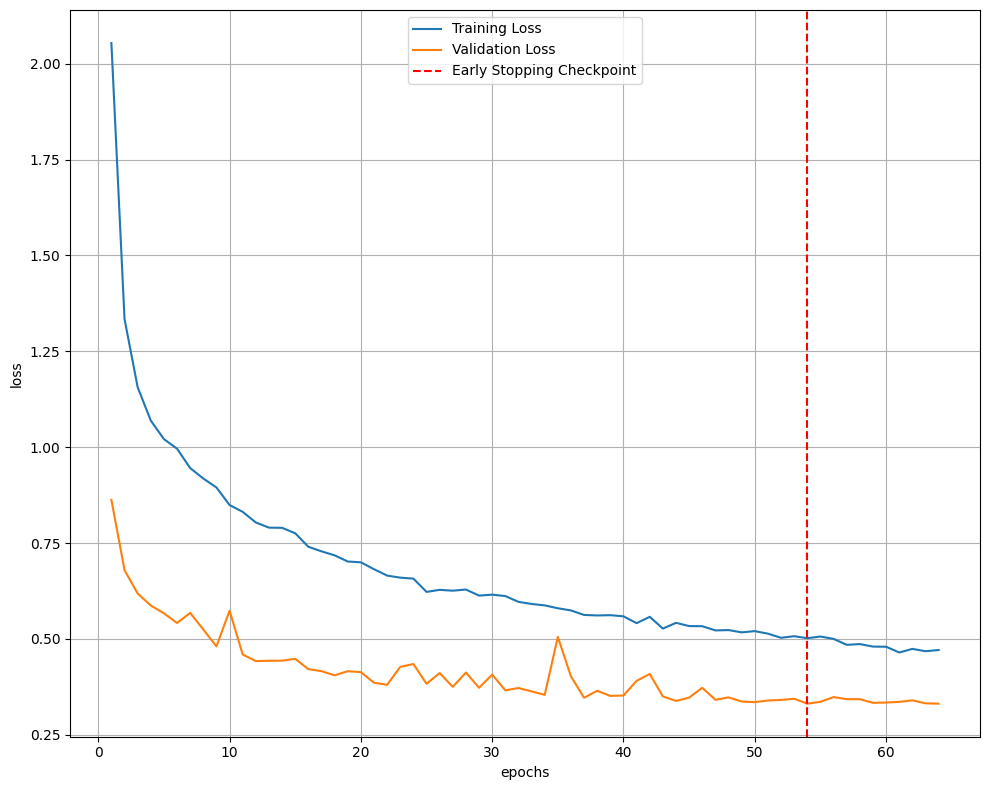

In [40]:
train_loss = model.train_loss_history
valid_loss = model.val_loss_history

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('img/cnn_loss_plot.png', bbox_inches='tight')

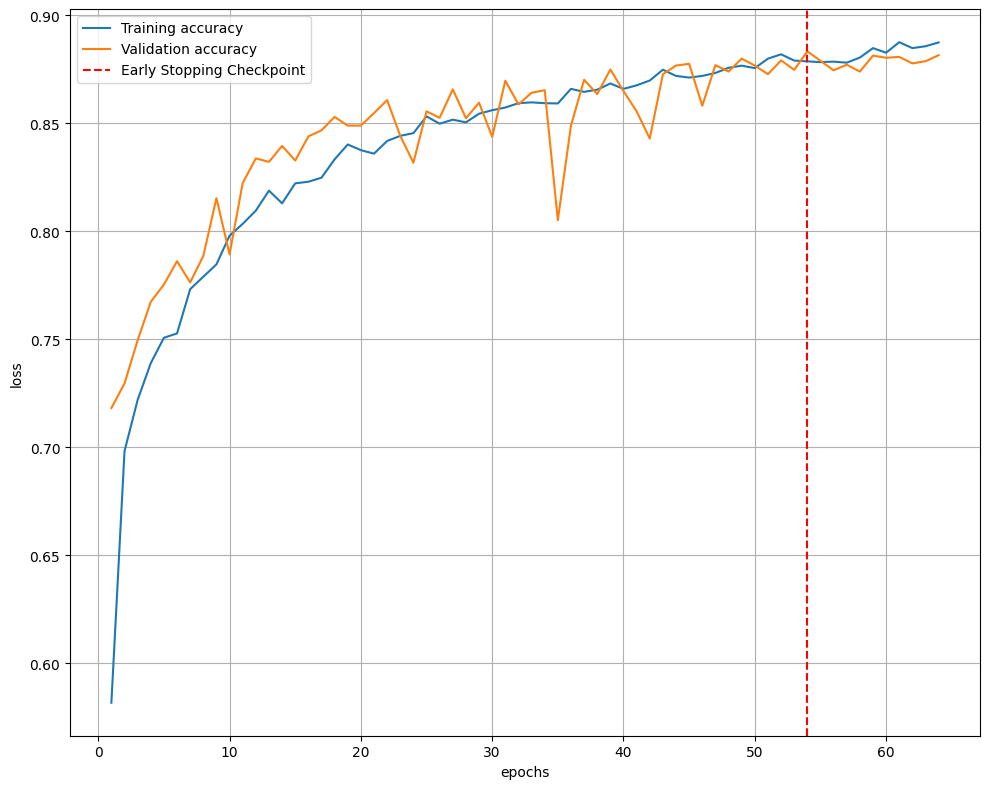

In [41]:
train_acc = model.train_acc_history
valid_acc = model.val_acc_history

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training accuracy')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation accuracy')

# find position of lowest validation loss
#minposs = valid_acc.index(min(valid_acc))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim(0, 0.5) # consistent scale
#plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('img/cnn_acc_plot.png', bbox_inches='tight')

In [42]:
model.test()

Accuracy score for test data
------------------------------------------------------------
Acc: 88.16000000000001 %

Confusion matrix for test data
------------------------------------------------------------
[[843   3  19  26 109]
 [  1 976   1  16   6]
 [ 13   3 864  11 109]
 [ 11   6   5 944  34]
 [126   0  60  33 781]]


### Summary

In [43]:
summary(model=model, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNN (CNN)                                [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (nn)                        [1, 1, 28, 28]       [1, 10]              --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─BatchNorm2d (1)                   [1, 6, 28, 28]       [1, 6, 28, 28]       12                   True
│    └─Sigmoid (2)                       [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (3)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (4)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─BatchNorm2d (5)                   [1, 16, 10, 10]      [1, 16, 10, 10]      32                   True
│    └─Sigmoid (6)